# Zestaw zadań: Równania różniczkowe - spectral bias
## Zadanie 1
### Autor: Artur Gęsiarz

In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

### Definicja analitycznego rozwiązania

In [29]:
def exact_solution(x, w):
    return (1/w) * torch.sin(w * x)

### Definicja sieci neuronowej

In [30]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Funkcja obliczajca koszt warunku poczatkowego

In [ ]:
def calculate_cond_start_cost(model, x_boundary):
    u0 = model(x_boundary)
    loss_ic = u0 ** 2
    return  loss_ic

### Funkcja obliczajca koszt rezydualny

In [ ]:
def calculate_residual_cost(model, x_physics, w):
    u = model(x_physics)
    du_dx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    residual = du_dx - torch.cos(w * x_physics)
    loss_r = torch.mean(residual**2)
    return loss_r

### Funkcja obliczajca koszt totalny

In [ ]:
def calculate_total_cost(model, x_boundary, x_physics, w):
    return calculate_cond_start_cost(model, x_boundary) + calculate_residual_cost(model, x_physics, w)

### Funkcja treningowa PINN

In [31]:
def train_PINN(model, x_boundary, x_physics, w, epochs=50000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for i in range(epochs):
        optimizer.zero_grad()

        loss = calculate_total_cost(model, x_boundary, x_physics, w)
        np.append(losses, loss.item())

        loss.backward()
        optimizer.step()

        if i % 5000 == 0:
            print(f'Epoch {i}, Loss: {loss.item()}')

    return losses

### Funkcja do rysowania wyników

In [32]:
def plot_results(x_test, u_exact, u_pred, losses, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x_test, u_exact, label='Exact solution')
    plt.plot(x_test, u_pred, '--', label='PINN solution')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Solution')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.suptitle(title)
    plt.show()

### Parametry naszego modelu

In [0]:
w_values = [15]
architectures = [(2, 16), (4, 64), (5, 128)]
train_points = [200, 3000]
test_points = [1000, 5000]

### Stałe w naszym modelu

In [33]:
LR = 0.001
EPOCHS = 50000

### Uruchomienie calego modelu

Training for w = 15, Layers = 2, Neurons = 16
Training orginal model
Epoch 0, Loss: 0.5441693663597107
Epoch 5000, Loss: 0.5021187663078308
Epoch 10000, Loss: 0.5013331174850464
Epoch 15000, Loss: 0.49935874342918396
Epoch 20000, Loss: 0.4847436547279358
Epoch 25000, Loss: 0.47979655861854553
Epoch 30000, Loss: 0.4639095366001129
Epoch 35000, Loss: 0.4427620470523834
Epoch 40000, Loss: 0.44056665897369385
Epoch 45000, Loss: 0.43901896476745605


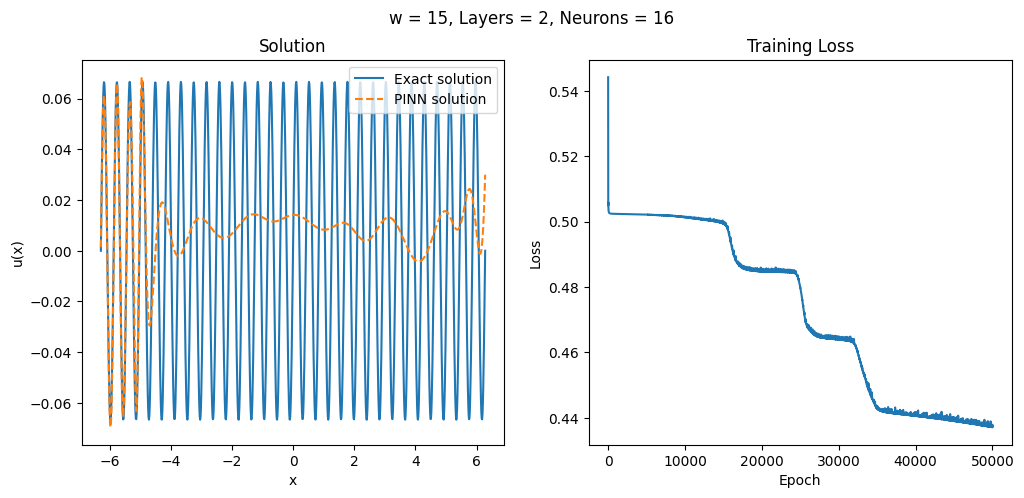

Training for w = 15, Layers = 4, Neurons = 64
Training orginal model
Epoch 0, Loss: 0.5621420741081238
Epoch 5000, Loss: 0.46850255131721497
Epoch 10000, Loss: 0.3170923888683319
Epoch 15000, Loss: 0.1604442149400711
Epoch 20000, Loss: 0.10278240591287613
Epoch 25000, Loss: 0.022447815164923668
Epoch 30000, Loss: 0.0006731113535352051
Epoch 35000, Loss: 0.0004476379253901541
Epoch 40000, Loss: 0.00029272446408867836
Epoch 45000, Loss: 0.0003441777953412384


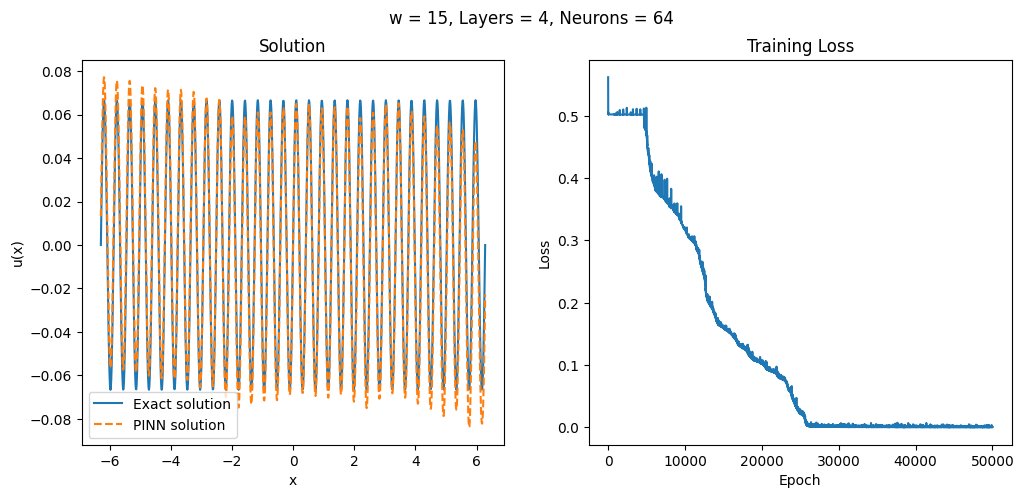

Training for w = 15, Layers = 5, Neurons = 128
Training orginal model
Epoch 0, Loss: 0.511497437953949
Epoch 5000, Loss: 0.5023996829986572
Epoch 10000, Loss: 0.5024163722991943
Epoch 15000, Loss: 0.39120039343833923
Epoch 20000, Loss: 0.15896214544773102
Epoch 25000, Loss: 0.007968034595251083
Epoch 30000, Loss: 0.0009047072962857783
Epoch 35000, Loss: 0.0010710760252550244
Epoch 40000, Loss: 0.0001835154980653897
Epoch 45000, Loss: 0.0009748739539645612


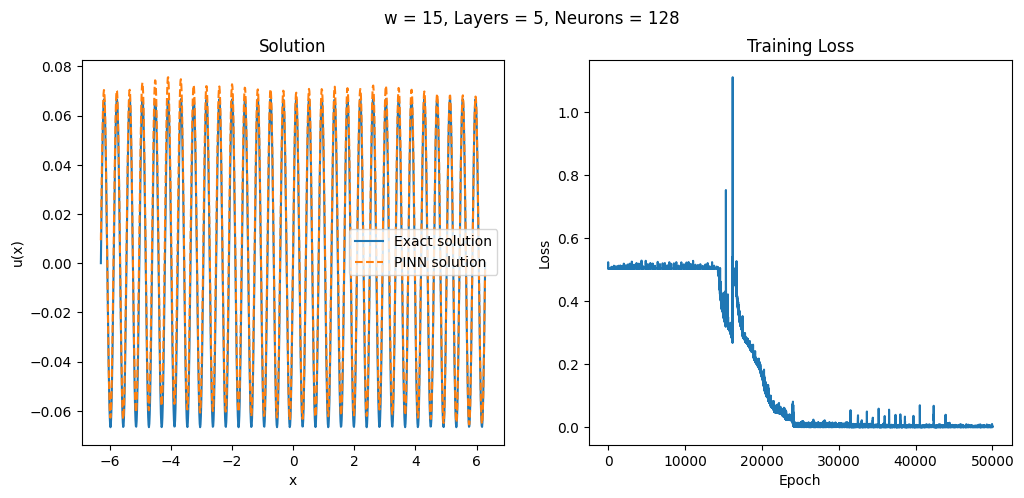

In [34]:
for w in w_values:
    for layers, neurons in architectures:
        print(f'Training for w = {w}, Layers = {layers}, Neurons = {neurons}')

        # Definicja orginalego modelu
        print("Training orginal model")

        model = FCN(1, 1, neurons, layers)

        # Definicja punktów treningowych i testowych
        x_boundary = torch.tensor([[0.0]], requires_grad=True)
        x_physics = torch.linspace(-2 * np.pi, 2 * np.pi, train_points[w_values.index(w)]).view(-1, 1).requires_grad_(True)
        x_test = torch.linspace(-2 * np.pi, 2 * np.pi, test_points[w_values.index(w)]).view(-1, 1)
        u_exact = exact_solution(x_test, w)

        # Trening modelu
        losses = train_PINN(model, x_boundary, x_physics, w, EPOCHS, LR)

        # Przewidywanie wartości
        u_pred = model(x_test).detach().numpy()
        u_exact = u_exact.numpy()

        # Rysowanie wyników
        plot_results(x_test, u_exact, u_pred, losses, f'w = {w}, Layers = {layers}, Neurons = {neurons}')
